In [1]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [3]:
(x_train, _), (x_test, _) = cifar10.load_data()

In [4]:
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
channels = x_train.shape[3]
imgs_dir = 'saved_images'
save_dir = os.path.join(os.getcwd(), imgs_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [5]:
imgs = x_test[:100]

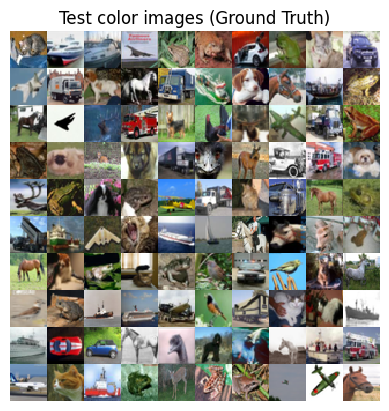

In [6]:
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground Truth)')
plt.imshow(imgs, interpolation = 'none')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [7]:
x_train_gray = rgb2gray(x_train)
x_test_gray = rgb2gray(x_test)

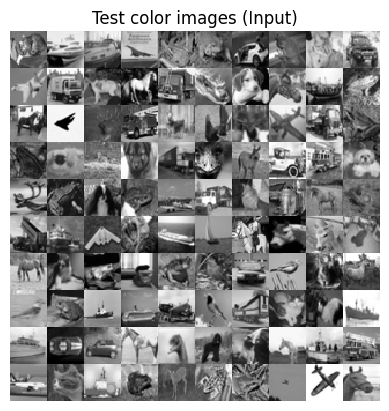

In [8]:
imgs = x_test_gray[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Input)')
plt.imshow(imgs, interpolation = 'none', cmap = 'gray')
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [9]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [10]:
x_train_gray = x_train_gray.astype('float32')/255
x_test_gray = x_test_gray.astype('float32')/255

In [11]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)


In [12]:
x_train_gray = x_train_gray.reshape(x_train_gray.shape[0], img_rows, img_cols, 1)
x_test_gray = x_test_gray.reshape(x_test_gray.shape[0], img_rows, img_cols, 1)


In [13]:
input_shape = (img_rows, img_cols, 1)
batch_size = 32
kernel_size = 3
latent_dim = 256
layers_filters = [64, 128, 256]

In [14]:
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

for filters in layers_filters:
    x = Conv2D(filters = filters,
               kernel_size = kernel_size,
               activation = 'relu',
               strides = 2,
               padding = 'same')(x)

In [15]:
shape = K.int_shape(x)

In [16]:
x = Flatten()(x)
latent = Dense(latent_dim, name = 'latent_vector')(x)

In [17]:
encoder = Model(inputs,
                latent,
                name = 'encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 latent_vector (Dense)       (None, 256)               1048832   
                                                                 
Total params: 1418496 (5.41 MB)
Trainable params: 1418496 (

In [18]:
latent_inputs = Input(shape =(latent_dim,), name = 'decoder_input')
x = Dense(shape[1] *shape[2]* shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [19]:
for filters in layers_filters[::-1]:
    x = Conv2DTranspose(filters = filters,
                        kernel_size = kernel_size,
                        activation = 'relu',
                        strides = 2,
                        padding = 'same')(x)

In [20]:
outputs = Conv2DTranspose(filters = channels,
                          kernel_size = kernel_size,
                          activation = 'sigmoid',
                          padding = 'same',
                          name = 'decoder_output',
                          )(x)

In [21]:
decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 4096)              1052672   
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         590080    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 64)        7379

In [22]:
autoencoder = Model(inputs, 
                    decoder(encoder (inputs)),
                    name = 'autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 encoder (Functional)        (None, 256)               1418496   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         2013315   
                                                                 
Total params: 3431811 (13.09 MB)
Trainable params: 3431811 (13.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'colorized_ae_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [24]:
lr_reduced = ReduceLROnPlateau(factor = np.sqrt(0.1),
                               cooldown = 0,
                               patience = 5,
                               verbose = 1,
                               min_lr = 0.5e-6)

checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True)

In [25]:
autoencoder.compile(loss = 'mse', optimizer='adam')

In [26]:
callbacks = [lr_reduced, checkpoint]

In [27]:
autoencoder.fit(x_train_gray,
                x_train,
                validation_data=(x_test_gray, x_test),
                epochs=3,
                batch_size=batch_size,
                callbacks = callbacks)

x_decoded = autoencoder.predict(x_test_gray)

Epoch 1/3

1563/1563 [==============================] - ETA: 0s - loss: 0.0157
Epoch 1: val_loss improved from inf to 0.01121, saving model to c:\Users\prave\TensorFlow\deep-learning-keras-tf-tutorial\AdvancedDeepLearning\saved_models\colorized_ae_model.001.h5
1563/1563 [==============================] - 125s 78ms/step - loss: 0.0157 - val_loss: 0.0112 - lr: 0.0010


C:\Users\prave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/3
1562/1563 [============================>.] - ETA: 0s - loss: 0.0103
Epoch 2: val_loss improved from 0.01121 to 0.00959, saving model to c:\Users\prave\TensorFlow\deep-learning-keras-tf-tutorial\AdvancedDeepLearning\saved_models\colorized_ae_model.002.h5
1563/1563 [==============================] - 127s 81ms/step - loss: 0.0103 - val_loss: 0.0096 - lr: 0.0010
Epoch 3/3
1562/1563 [============================>.] - ETA: 0s - loss: 0.0093
Epoch 3: val_loss improved from 0.00959 to 0.00909, saving model to c:\Users\prave\TensorFlow\deep-learning-keras-tf-tutorial\AdvancedDeepLearning\saved_models\colorized_ae_model.003.h5
313/313 [==============================] - 8s 26ms/step


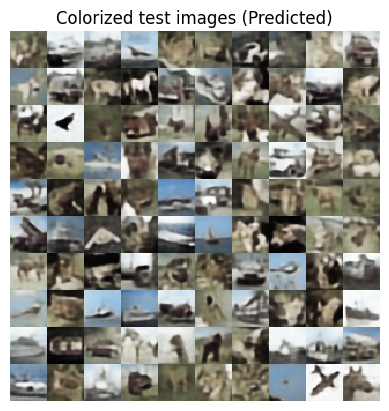

In [29]:
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('%s/colorized.png' % imgs_dir)
plt.show()